In [74]:
# Quick test of the optimization feature
print("Testing Fee Optimization Feature...")
print("=====================================")

# First test without optimization
print("\n1. Testing WITHOUT optimization:")
exec("""
OPTIMIZE_MONTHLY_FEES = False
MONTHLY_FEES = 120000 / 12  # $10,000/month

# Run a quick 5-year simulation to test
original_period = PERIOD
PERIOD = 5

exec(open('workbook.py').read())

# Show a few results
print(f"Using original fees: ${MONTHLY_FEES:,.2f}/month")
print(f"Year 5 closing balance: ${data[4]['closing_balance']:,.2f}")
deficit_years = sum(1 for d in data if d['closing_balance'] < 0)
print(f"Years with deficits: {deficit_years}")

PERIOD = original_period
""")

print("\n" + "="*50)

# Now test with optimization
print("\n2. Testing WITH optimization:")
exec("""
OPTIMIZE_MONTHLY_FEES = True  
MONTHLY_FEES = 120000 / 12  # Start with same $10,000/month

# Run the optimization
PERIOD = 5
exec(open('workbook.py').read())

print(f"Optimized fees: ${optimized_monthly_fees:,.2f}/month")
print(f"Year 5 closing balance: ${data[4]['closing_balance']:,.2f}")
deficit_years = sum(1 for d in data if d['closing_balance'] < 0)
print(f"Years with deficits: {deficit_years}")

PERIOD = original_period
""")


Testing Fee Optimization Feature...

1. Testing WITHOUT optimization:
Optimizing monthly fees to eliminate deficits...
Current monthly fees of $10,000.00 are already optimal.
SOCIETY MAINTENANCE MODEL - LOAN AND SAFETY NET SIMULATION

EXPENSE SCHEDULE:
--------------------------------------------------
Year 2023 (Year 2): $5,000.00
  - HVAC Maintenance: $5,000.00 (Small)

Year 2026 (Year 5): $5,000.00
  - HVAC Maintenance: $5,000.00 (Small)

Year 2027 (Year 6): $50,000.00
  - Roof Replacement: $50,000.00 (Large)

Year 2029 (Year 8): $5,000.00
  - HVAC Maintenance: $5,000.00 (Small)


FINANCIAL PROJECTIONS (First 10 Years):
--------------------------------------------------------------------------------
Year   Opening      Base Maint   Expenses     Loans      Safety Net   Closing     
--------------------------------------------------------------------------------
2022   $0           $120,000     $0           $0         $0           $148,397    
2023   $148,397     $126,000     $5,250  

In [75]:
# Test the updated workbook.py implementation
exec(open('workbook.py').read())


Optimizing monthly fees to eliminate deficits...
Current monthly fees of $10,000.00 are already optimal.
SOCIETY MAINTENANCE MODEL - LOAN AND SAFETY NET SIMULATION

EXPENSE SCHEDULE:
--------------------------------------------------
Year 2023 (Year 2): $5,000.00
  - HVAC Maintenance: $5,000.00 (Small)

Year 2026 (Year 5): $5,000.00
  - HVAC Maintenance: $5,000.00 (Small)

Year 2027 (Year 6): $50,000.00
  - Roof Replacement: $50,000.00 (Large)

Year 2029 (Year 8): $5,000.00
  - HVAC Maintenance: $5,000.00 (Small)


FINANCIAL PROJECTIONS (First 10 Years):
--------------------------------------------------------------------------------
Year   Opening      Base Maint   Expenses     Loans      Safety Net   Closing     
--------------------------------------------------------------------------------
2022   $0           $120,000     $0           $0         $0           $148,397    
2023   $148,397     $126,000     $5,250       $0         $0           $300,850    
2024   $300,850     $132,300

In [76]:
# Imports
# import pandas as pd
# import numpy as np

# inputs

# Model inputs
MODEL = "Society Maintenance Model"
STARTING_BALANCE = 0
MONTHLY_FEES = 92
MAXIMUM_FEE_INCREASE = 13  # percentage
HOUSING = 1  # Set to 1 since MONTHLY_FEES already represents total
FISCAL_YEAR = 2022
PERIOD = 30
IMMEDIATE_ASSESSMENT = 0
LOAN_AMOUNT = 0  # Principal loan amount (legacy, now handled dynamically)
LOAN_TERM_YEARS = 10
ANNUAL_LOAN_INTEREST_RATE = 6  # percentage
LIQUIDATED_INVESTMENT_PRINCIPAL = 0
LIQUIDATED_EARNINGS = 0
BANK_SAVINGS_INTEREST_RATE = 2  # percentage
LTIM_PERCENTAGE = 0  # percentage
LTIM_RETURN_RATE = 4  # percentage
ANNUAL_INVESTMENT_RETURN_RATE = 5  # percentage
INFLATION_RATE = 5  # percentage - matches Society Maintenance Model

# Additional inputs for proper financial calculations
INVESTMENT_AMOUNT_COMPOUND = 0  # Amount allocated for compound growth
AMOUNT_ALLOCATED_TO_LTIM = 0  # Amount allocated to LTIM

# Loan and Safety Net parameters (based on Society Maintenance Model)
LOAN_THRESHOLD_PERCENTAGE = 70  # percentage - portion of large expenses that can be financed
LOAN_RATE_PERCENTAGE = 10  # percentage - annual interest rate for loans
LOAN_TERM_YEARS_MODEL = 5  # years - loan repayment term
SAFETY_NET_PERCENTAGE = 10  # percentage - safety net as % of total collections

# Fee Optimization parameters
OPTIMIZE_MONTHLY_FEES = True  # When True, automatically adjust fees to eliminate deficits
MIN_RESERVE_BALANCE = 0  # Minimum reserve balance to maintain
OPTIMIZATION_TOLERANCE = 1000  # Tolerance for deficit elimination ($)

# expenses - Test data with both one-time and recurring items
MODEL_ITEMS = [
    {
        "name": "Roof Replacement",
        "redundancy": 20,  # Every 20 years
        "remaining_life": 5,  # First occurrence in year 5
        "cost": 50000,
        "is_sirs": False,
        "type": "Large",
    },
    {
        "name": "HVAC Maintenance",
        "redundancy": 3,  # Every 3 years
        "remaining_life": 1,  # First occurrence in year 1
        "cost": 5000,
        "is_sirs": False,
        "type": "Small",
    },
    {
        "name": "Elevator Modernization",
        "redundancy": 25,  # Every 25 years
        "remaining_life": 15,  # First occurrence in year 15
        "cost": 75000,
        "is_sirs": False,
        "type": "Large",
    },
    {
        "name": "Plumbing riser replacement",
        "redundancy": 1,  # One-time only
        "remaining_life": 22,
        "cost": 80000,
        "is_sirs": False,
        "type": "Large",
    },
]


# formulas
def calculate_yearly_expenses(model_items, period_years, start_year):
    """
    Calculate yearly expenses following the documented algorithm.
    Returns: (spendings_array, spending_data_array)
    """
    # Initialize spending arrays
    spendings = [0] * period_years  # Total spending per year
    spending_data = [[] for _ in range(period_years)]  # Detailed items per year
    
    for item in model_items:
        remaining_life = item["remaining_life"]
        redundancy = item["redundancy"]
        cost = item["cost"]
        
        # Skip items that occur beyond simulation period
        if remaining_life >= period_years:
            continue
        
        # Calculate number of occurrences within period
        if redundancy <= 1:
            # One-time occurrence
            redundancies = 1
        else:
            # Recurring occurrences
            redundancies = ((period_years - remaining_life) // redundancy) + 1
        
        # Place each occurrence in appropriate year
        for i in range(redundancies):
            occurrence_year = remaining_life + (i * redundancy)
            
            if occurrence_year < period_years:
                # Add cost to year's total expenses
                spendings[occurrence_year] += cost
                
                # Store detailed item information
                spending_data[occurrence_year].append({
                    'name': item['name'],
                    'cost': cost,
                    'year': occurrence_year,
                    'redundancy_at': i,
                    'type': item.get('type', 'Small'),
                    'is_sirs': item.get('is_sirs', False)
                })
    
    return spendings, spending_data


def get_expenses_with_loan_details(year: int, housing: int):
    """
    Calculate annual expenses from model items based on replacement schedules.
    Returns tuple: (total_expenses, large_expenses, loan_portion, cash_portion)
    Uses the corrected algorithm from documentation.
    """
    total_expenses = 0
    large_expenses = 0
    loan_portion = 0
    cash_portion = 0
    
    # Calculate year index from start of simulation
    year_index = year - FISCAL_YEAR
    
    # Pre-calculate all expenses if not done already
    if not hasattr(get_expenses_with_loan_details, '_cached_expenses'):
        spendings, spending_data = calculate_yearly_expenses(MODEL_ITEMS, PERIOD, FISCAL_YEAR)
        get_expenses_with_loan_details._cached_expenses = (spendings, spending_data)
    
    spendings, spending_data = get_expenses_with_loan_details._cached_expenses
    
    # Get expenses for this specific year
    if 0 <= year_index < len(spendings):
        items_this_year = spending_data[year_index]
        
        for item_data in items_this_year:
            # Apply inflation from start year to current year
            years_of_inflation = year_index
            inflated_cost = item_data['cost'] * (1 + INFLATION_RATE / 100) ** years_of_inflation
            total_expenses += inflated_cost
            
            # Track large vs small expenses for loan calculations
            if item_data['type'].upper() == "LARGE":
                large_expenses += inflated_cost
                # For large expenses, calculate loan vs cash portions
                loan_amount = inflated_cost * (LOAN_THRESHOLD_PERCENTAGE / 100)
                cash_amount = inflated_cost - loan_amount
                loan_portion += loan_amount
                cash_portion += cash_amount
            else:
                # Small expenses are paid fully in cash
                cash_portion += inflated_cost
    
    return total_expenses, large_expenses, loan_portion, cash_portion


def get_expenses(year: int, housing: int):
    """
    Legacy function - returns only total expenses for backwards compatibility.
    """
    total_expenses, _, _, _ = get_expenses_with_loan_details(year, housing)
    return total_expenses


def get_total_available_to_invest(
    starting_balance: int,
    immediate_assessment: int,
    loan_amount: int,
    liquidated_investment_principal: int,
    liquidated_earnings: int,
    yearly_collections: int,
):
    """
    DEPRECATED: This calculates the initial total funds available.
    Use get_available_to_invest_for_year() for year-specific calculations.
    """
    return (
        starting_balance
        + immediate_assessment
        + loan_amount
        + liquidated_investment_principal
        + liquidated_earnings
        + yearly_collections
    )


def get_available_to_invest_for_year(
    starting_amount: int,
    planned_spending: int,
    loss_in_purchasing_power: int,
    investment_strategy_amount: int,
):
    """
    Calculate Available to Invest for a specific year.
    Formula: Starting Amount - Planned Spending this year - Loss in Purchase power - Amount of Investment Strategy
    This amount changes each year based on inflation rate and investment strategy.
    """
    return starting_amount - planned_spending - loss_in_purchasing_power - investment_strategy_amount


def get_total_amount_invested(
    total_available_to_invest: int,
    ltim_percentage: int,
):
    """
    Total amount invested is the total available to invest multiplied by the ltim percentage.
    """
    return total_available_to_invest * ltim_percentage / 100


def get_net_earnings(
    total_amount_invested: int,
    annual_investment_return_rate: int,
):
    """
    Net earnings are calculated by multiplying the total amount invested by the annual investment return rate.
    """
    return total_amount_invested * annual_investment_return_rate / 100


def get_loss_in_purchasing_power(
    total_available_to_invest: int,
    inflation_rate: int,
):
    """
    Loss in purchasing power is calculated by multiplying the total available to invest by the inflation rate.
    Formula: Total Available To Invest × Inflation Rate
    """
    return total_available_to_invest * inflation_rate / 100


def calculate_monthly_loan_payment(
    principal: int,
    annual_interest_rate: int,
    loan_term_years: int,
):
    """
    Calculate monthly loan payment using standard amortization formula.
    Formula: P × (r/12) × (1 + r/12)^(n×12) / [(1 + r/12)^(n×12) - 1]
    Where P = Principal, r = Annual interest rate, n = Loan term in years
    """
    if principal == 0 or annual_interest_rate == 0:
        return 0
    
    monthly_rate = annual_interest_rate / 100 / 12
    number_of_payments = loan_term_years * 12
    
    numerator = principal * monthly_rate * (1 + monthly_rate) ** number_of_payments
    denominator = (1 + monthly_rate) ** number_of_payments - 1
    
    return numerator / denominator


def get_loan_payments(
    principal: int,
    annual_interest_rate: int,
    loan_term_years: int,
):
    """
    Annual loan payments are calculated as Monthly Loan Payment × 12.
    """
    monthly_payment = calculate_monthly_loan_payment(principal, annual_interest_rate, loan_term_years)
    return monthly_payment * 12


def get_remaining_amount(
    total_available_to_invest: int,
    net_earnings: int,
    compound_value_of_savings: int,
    projected_ltim_earnings: int,
    loss_in_purchasing_power: int,
    loan_payments: int,
    expenses: int,
):
    """
    Remaining amount is calculated using the complete formula from the documentation.
    Formula: Total Available To Invest + Net Earnings + Compound Value of Savings + 
    Projected LTIM Earnings - Loss in Purchasing Power - Expenses - Loan Payments
    """
    return (
        total_available_to_invest
        + net_earnings
        + compound_value_of_savings
        + projected_ltim_earnings
        - loss_in_purchasing_power
        - expenses
        - loan_payments
    )


def get_compound_value_of_savings(
    investment_amount_compound: int,
    bank_savings_interest_rate: int,
):
    """
    Compound value of savings is calculated by applying bank savings interest to the compound investment amount.
    Formula: Investment Amount Taken for Compound × (1 + Bank Savings Interest Rate)
    """
    return investment_amount_compound * (1 + bank_savings_interest_rate / 100)


def get_projected_ltim_earnings(
    amount_allocated_to_ltim: int,
    ltim_return_rate: int,
):
    """
    Projected LTIM earnings are calculated by multiplying the amount allocated to LTIM by the LTIM return rate.
    Formula: Amount Allocated to LTIM × LTIM Return Rate
    """
    return amount_allocated_to_ltim * (ltim_return_rate / 100)


# Loan and Safety Net functions
def calculate_reserve_contribution_for_future_expenses(future_expenses_by_year: dict, current_year: int):
    """
    Calculate reserve contribution needed for future expenses.
    Formula: Sum of (Future Large Expenses × Loan Threshold %) / (Years until expense - 1)
    """
    reserve_contribution = 0
    
    for expense_year, (large_expenses, _) in future_expenses_by_year.items():
        if expense_year > current_year and large_expenses > 0:
            # Calculate contribution needed for this future expense
            years_until_expense = max(expense_year - current_year, 1)
            annual_contribution = (large_expenses * (LOAN_THRESHOLD_PERCENTAGE / 100)) / years_until_expense
            reserve_contribution += annual_contribution
    
    return reserve_contribution


def calculate_loan_payments_for_year(active_loans: list, year: int):
    """
    Calculate total loan payments for a given year based on active loans.
    Each loan in active_loans should be: {'principal': amount, 'start_year': year, 'term': years}
    """
    total_payments = 0
    
    for loan in active_loans:
        loan_start = loan['start_year']
        loan_end = loan_start + loan['term']
        
        if loan_start <= year < loan_end:
            # This loan is active in this year
            annual_payment = get_loan_payments(
                loan['principal'],
                LOAN_RATE_PERCENTAGE,
                loan['term']
            )
            total_payments += annual_payment
    
    return total_payments


def calculate_safety_net_target(base_maintenance: float, future_expenses: float, loan_repayments: float):
    """
    Calculate safety net target.
    Formula: Safety Net % × (Base Maintenance + Future Expenses + Loan Repayments)
    """
    total_collections = base_maintenance + future_expenses + loan_repayments
    return total_collections * (SAFETY_NET_PERCENTAGE / 100)


def calculate_safety_net_top_up(safety_net_target: float, provisional_end_balance: float):
    """
    Calculate safety net top-up amount.
    Formula: max(0, Safety Net Target - Provisional End Balance)
    """
    return max(0, safety_net_target - provisional_end_balance)


# Fee Optimization functions
def simulate_with_monthly_fees(monthly_fees_override=None):
    """
    Run the complete simulation with given monthly fees.
    Returns: (data, min_balance, total_deficits)
    """
    # Use override fees if provided, otherwise use global setting
    effective_monthly_fees = monthly_fees_override if monthly_fees_override is not None else MONTHLY_FEES
    
    # Initialize loan tracking
    active_loans = []
    
    # Pre-calculate all future expenses
    future_expenses_by_year = {}
    for year in range(FISCAL_YEAR, FISCAL_YEAR + PERIOD):
        total_exp, large_exp, loan_portion, cash_portion = get_expenses_with_loan_details(year, HOUSING)
        future_expenses_by_year[year] = (large_exp, total_exp)
    
    simulation_data = []
    min_balance = float('inf')
    total_deficits = 0
    
    for year in range(FISCAL_YEAR, FISCAL_YEAR + PERIOD):
        # Get starting balance (opening balance)
        if year == FISCAL_YEAR:
            opening_balance = STARTING_BALANCE
        else:
            opening_balance = simulation_data[-1]["closing_balance"]
        
        # Calculate base maintenance (inflated) with effective monthly fees
        years_from_start = year - FISCAL_YEAR
        base_maintenance = effective_monthly_fees * HOUSING * 12 * (1 + INFLATION_RATE / 100) ** years_from_start
        
        # Get expense details for this year
        total_expenses, large_expenses, loan_portion, cash_portion = get_expenses_with_loan_details(year, HOUSING)
        
        # Create new loans for large expenses this year
        if loan_portion > 0:
            new_loan = {
                'principal': loan_portion,
                'start_year': year,
                'term': LOAN_TERM_YEARS_MODEL
            }
            active_loans.append(new_loan)
        
        # Calculate reserve contribution for future expenses
        reserve_contribution = calculate_reserve_contribution_for_future_expenses(future_expenses_by_year, year)
        
        # Calculate loan repayments for active loans
        loan_repayments = calculate_loan_payments_for_year(active_loans, year)
        
        # Collections without safety net
        collections_without_safety_net = base_maintenance + reserve_contribution + loan_repayments
        
        # Provisional end balance (before safety net)
        provisional_end_balance = opening_balance + collections_without_safety_net - total_expenses - loan_repayments
        
        # Calculate safety net
        safety_net_target = calculate_safety_net_target(base_maintenance, total_expenses, loan_repayments)
        safety_net_top_up = calculate_safety_net_top_up(safety_net_target, provisional_end_balance)
        
        # Total maintenance collected (including safety net top-up)
        total_maintenance_collected = collections_without_safety_net + safety_net_top_up
        
        # Final closing balance
        closing_balance = opening_balance + total_maintenance_collected - total_expenses - loan_repayments
        
        # Track minimum balance and deficits
        min_balance = min(min_balance, closing_balance)
        if closing_balance < MIN_RESERVE_BALANCE:
            total_deficits += abs(closing_balance - MIN_RESERVE_BALANCE)
        
        simulation_data.append({
            "year": year,
            "opening_balance": opening_balance,
            "base_maintenance": base_maintenance,
            "future_expenses_in_year": total_expenses,
            "reserve_contribution": reserve_contribution,
            "loan_repayments": loan_repayments,
            "collections_without_safety_net": collections_without_safety_net,
            "provisional_end_balance": provisional_end_balance,
            "safety_net_target": safety_net_target,
            "safety_net_top_up": safety_net_top_up,
            "total_maintenance_collected": total_maintenance_collected,
            "closing_balance": closing_balance,
            "large_expenses": large_expenses,
            "loan_portion": loan_portion,
            "cash_portion": cash_portion,
            "active_loans_count": len([loan for loan in active_loans if loan['start_year'] <= year < loan['start_year'] + loan['term']]),
        })
    
    return simulation_data, min_balance, total_deficits


def optimize_monthly_fees():
    """
    Use binary search to find optimal monthly fees that eliminate deficits.
    Returns: optimized_monthly_fees
    """
    if not OPTIMIZE_MONTHLY_FEES:
        return MONTHLY_FEES
    
    print("Optimizing monthly fees to eliminate deficits...")
    
    # Initial bounds for binary search
    lower_bound = MONTHLY_FEES * 0.5  # Start with 50% of original
    upper_bound = MONTHLY_FEES * 3.0  # Cap at 300% of original
    
    # First check if current fees are already sufficient
    _, min_balance, total_deficits = simulate_with_monthly_fees(MONTHLY_FEES)
    if min_balance >= MIN_RESERVE_BALANCE and total_deficits <= OPTIMIZATION_TOLERANCE:
        print(f"Current monthly fees of ${MONTHLY_FEES:,.2f} are already optimal.")
        return MONTHLY_FEES
    
    # Binary search for optimal fees
    max_iterations = 20
    iteration = 0
    
    while iteration < max_iterations and (upper_bound - lower_bound) > 1.0:
        iteration += 1
        mid_fees = (lower_bound + upper_bound) / 2
        
        _, min_balance, total_deficits = simulate_with_monthly_fees(mid_fees)
        
        print(f"  Iteration {iteration}: Fees ${mid_fees:,.2f} -> Min Balance: ${min_balance:,.2f}, Deficits: ${total_deficits:,.2f}")
        
        if min_balance >= MIN_RESERVE_BALANCE and total_deficits <= OPTIMIZATION_TOLERANCE:
            # Fees are sufficient, try lower
            upper_bound = mid_fees
        else:
            # Fees are insufficient, need higher
            lower_bound = mid_fees
    
    # Use the upper bound as the optimal fee (ensures no deficits)
    optimized_fees = upper_bound
    
    # Validate the result
    _, min_balance, total_deficits = simulate_with_monthly_fees(optimized_fees)
    
    print("Optimization complete!")
    print(f"  Original fees: ${MONTHLY_FEES:,.2f}")
    print(f"  Optimized fees: ${optimized_fees:,.2f}")
    print(f"  Fee increase: {((optimized_fees / MONTHLY_FEES - 1) * 100):,.1f}%")
    print(f"  Final min balance: ${min_balance:,.2f}")
    print(f"  Total deficits: ${total_deficits:,.2f}")
    print()
    
    return optimized_fees


# build years data

# Optimize monthly fees if enabled
if OPTIMIZE_MONTHLY_FEES:
    optimized_monthly_fees = optimize_monthly_fees()
else:
    optimized_monthly_fees = MONTHLY_FEES

# Run simulation with optimized fees
data, min_balance_achieved, total_deficits_achieved = simulate_with_monthly_fees(optimized_monthly_fees)

# Legacy simulation loop for backward compatibility
# (The actual data is now generated by simulate_with_monthly_fees)
active_loans = []
future_expenses_by_year = {}
for year in range(FISCAL_YEAR, FISCAL_YEAR + PERIOD):
    total_exp, large_exp, loan_portion, cash_portion = get_expenses_with_loan_details(year, HOUSING)
    future_expenses_by_year[year] = (large_exp, total_exp)

# Add legacy fields to data for compatibility (with optimized monthly fees)
for i, year_data in enumerate(data):
    year = year_data['year']
    
    # Legacy calculations for compatibility using optimized fees
    yearly_collections = year_data['total_maintenance_collected']
    
    # Calculate initial total funds available (one-time calculation)
    initial_total_funds = get_total_available_to_invest(
        year_data['opening_balance'],
        IMMEDIATE_ASSESSMENT,
        0,
        LIQUIDATED_INVESTMENT_PRINCIPAL,
        LIQUIDATED_EARNINGS,
        yearly_collections
    )
    
    # Calculate loss in purchasing power based on initial funds
    loss_in_purchasing_power = get_loss_in_purchasing_power(
        initial_total_funds,
        INFLATION_RATE,
    )
    
    # Calculate investment strategy amounts
    investment_strategy_amount = INVESTMENT_AMOUNT_COMPOUND + AMOUNT_ALLOCATED_TO_LTIM
    
    # Calculate Available to Invest for this specific year (corrected formula)
    total_available_to_invest = get_available_to_invest_for_year(
        initial_total_funds,
        year_data['future_expenses_in_year'],  # Planned spending this year
        loss_in_purchasing_power,
        investment_strategy_amount
    )

    # get total amount invested
    total_amount_invested = get_total_amount_invested(
        total_available_to_invest,
        LTIM_PERCENTAGE,
    )

    net_earnings = get_net_earnings(
        total_amount_invested,
        ANNUAL_INVESTMENT_RETURN_RATE,
    )

    compound_value_of_savings = get_compound_value_of_savings(
        INVESTMENT_AMOUNT_COMPOUND,
        BANK_SAVINGS_INTEREST_RATE,
    )
    
    projected_ltim_earnings = get_projected_ltim_earnings(
        AMOUNT_ALLOCATED_TO_LTIM,
        LTIM_RETURN_RATE,
    )

    remaining_amount = get_remaining_amount(
        total_available_to_invest,
        net_earnings,
        compound_value_of_savings,
        projected_ltim_earnings,
        loss_in_purchasing_power,
        year_data['loan_repayments'],
        year_data['future_expenses_in_year'],
    )

    # Add legacy fields to existing data
    data[i].update({
        # Legacy fields for compatibility
        "starting_balance": year_data['opening_balance'],
        "yearly_collections": yearly_collections,
        "total_available_to_invest": total_available_to_invest,
        "total_amount_invested": total_amount_invested,
        "net_earnings": net_earnings,
        "projected_ltim_earnings": projected_ltim_earnings,
        "loss_in_purchasing_power": loss_in_purchasing_power,
        "loan_payments": year_data['loan_repayments'],  # renamed for consistency
        "expenses": year_data['future_expenses_in_year'],
        "compound_value_of_savings": compound_value_of_savings,
        "remaining_amount": remaining_amount,
        # Store optimized monthly fees used
        "optimized_monthly_fees": optimized_monthly_fees,
    })



Optimizing monthly fees to eliminate deficits...
Current monthly fees of $92.00 are already optimal.


In [77]:
# Imports
import pandas as pd

# inputs

# create a dataframe from the data
df = pd.DataFrame(data)

# Create a formatted version of the dataframe for display
df_display = df.copy()

# List of columns that should be formatted as currency
currency_columns = [
    "opening_balance",
    "yearly_collections",
    "total_available_to_invest",
    "total_amount_invested",
    "net_earnings",
    "projected_ltim_earnings",
    "loss_in_purchasing_power",
    "loan_payments",
    "expenses",
    "compound_value_of_savings",
    "remaining_amount",
    "base_maintenance",
    "future_expenses_in_year",
    "reserve_contribution",
    "loan_repayments",
    "collections_without_safety_net",
    "provisional_end_balance",
    "safety_net_target",
    "safety_net_top_up",
    "total_maintenance_collected",
    "closing_balance",
    "large_expenses",
    "loan_portion",
    "cash_portion",
    "active_loans_count",
]

# Format currency columns
for col in currency_columns:
    if col in df_display.columns:
        df_display[col] = df_display[col].apply(lambda x: f"${x:,.0f}")

# Display the formatted dataframe
print("📊 Financial Projection Results")
print("=" * 50)
df_display

📊 Financial Projection Results


,year,opening_balance,base_maintenance,future_expenses_in_year,reserve_contribution,loan_repayments,collections_without_safety_net,provisional_end_balance,safety_net_target,safety_net_top_up,...,total_available_to_invest,total_amount_invested,net_earnings,projected_ltim_earnings,loss_in_purchasing_power,loan_payments,expenses,compound_value_of_savings,remaining_amount,optimized_monthly_fees
0,2022,$0,"$1,104",$0,"$28,397",$0,"$29,501","$29,501",$110,$0,...,"$28,026",$0,$0,$0,"$1,475",$0,$0,$0,"$26,551",92
1,2023,"$29,501","$1,159","$5,250","$31,703",$0,"$32,862","$57,113",$641,$0,...,"$53,995",$0,$0,$0,"$3,118",$0,"$5,250",$0,"$45,627",92
2,2024,"$57,113","$1,217",$0,"$36,630",$0,"$37,847","$94,960",$122,$0,...,"$90,212",$0,$0,$0,"$4,748",$0,$0,$0,"$85,464",92
3,2025,"$94,960","$1,278",$0,"$45,439",$0,"$46,717","$141,677",$128,$0,...,"$134,593",$0,$0,$0,"$7,084",$0,$0,$0,"$127,509",92
4,2026,"$141,677","$1,342","$6,078","$69,337",$0,"$70,679","$206,278",$742,$0,...,"$195,660",$0,$0,$0,"$10,618",$0,"$6,078",$0,"$178,965",92
5,2027,"$206,278","$1,409","$63,814","$26,477","$11,389","$39,275","$170,350","$7,661",$0,...,"$169,461",$0,$0,$0,"$12,278","$11,389","$63,814",$0,"$81,980",92
6,2028,"$170,350","$1,479",$0,"$28,604","$11,389","$41,472","$200,433","$1,287",$0,...,"$201,231",$0,$0,$0,"$10,591","$11,389",$0,$0,"$179,251",92
7,2029,"$200,433","$1,553","$7,036","$31,149","$11,389","$44,091","$226,099","$1,998",$0,...,"$225,262",$0,$0,$0,"$12,226","$11,389","$7,036",$0,"$194,611",92
8,2030,"$226,099","$1,631",$0,"$34,265","$11,389","$47,285","$261,995","$1,302",$0,...,"$259,715",$0,$0,$0,"$13,669","$11,389",$0,$0,"$234,657",92
9,2031,"$261,995","$1,713",$0,"$38,199","$11,389","$51,301","$301,907","$1,310",$0,...,"$297,632",$0,$0,$0,"$15,665","$11,389",$0,$0,"$270,578",92


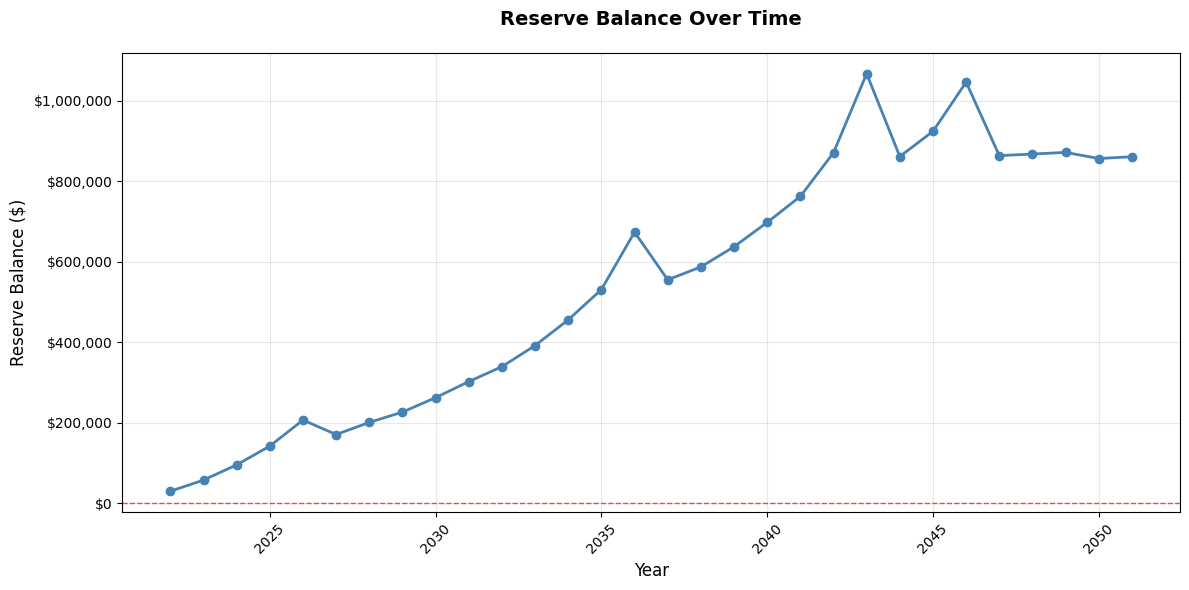

In [78]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt


# Create a professional line chart of the remaining amount
plt.figure(figsize=(12, 6))
plt.plot(df['year'], df['closing_balance'], marker='o', linewidth=2, markersize=6, color='steelblue')

# Add horizontal line at zero
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=1)

# Formatting
plt.title('Reserve Balance Over Time', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Reserve Balance ($)', fontsize=12)
plt.grid(True, alpha=0.3)

# Format y-axis as currency
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

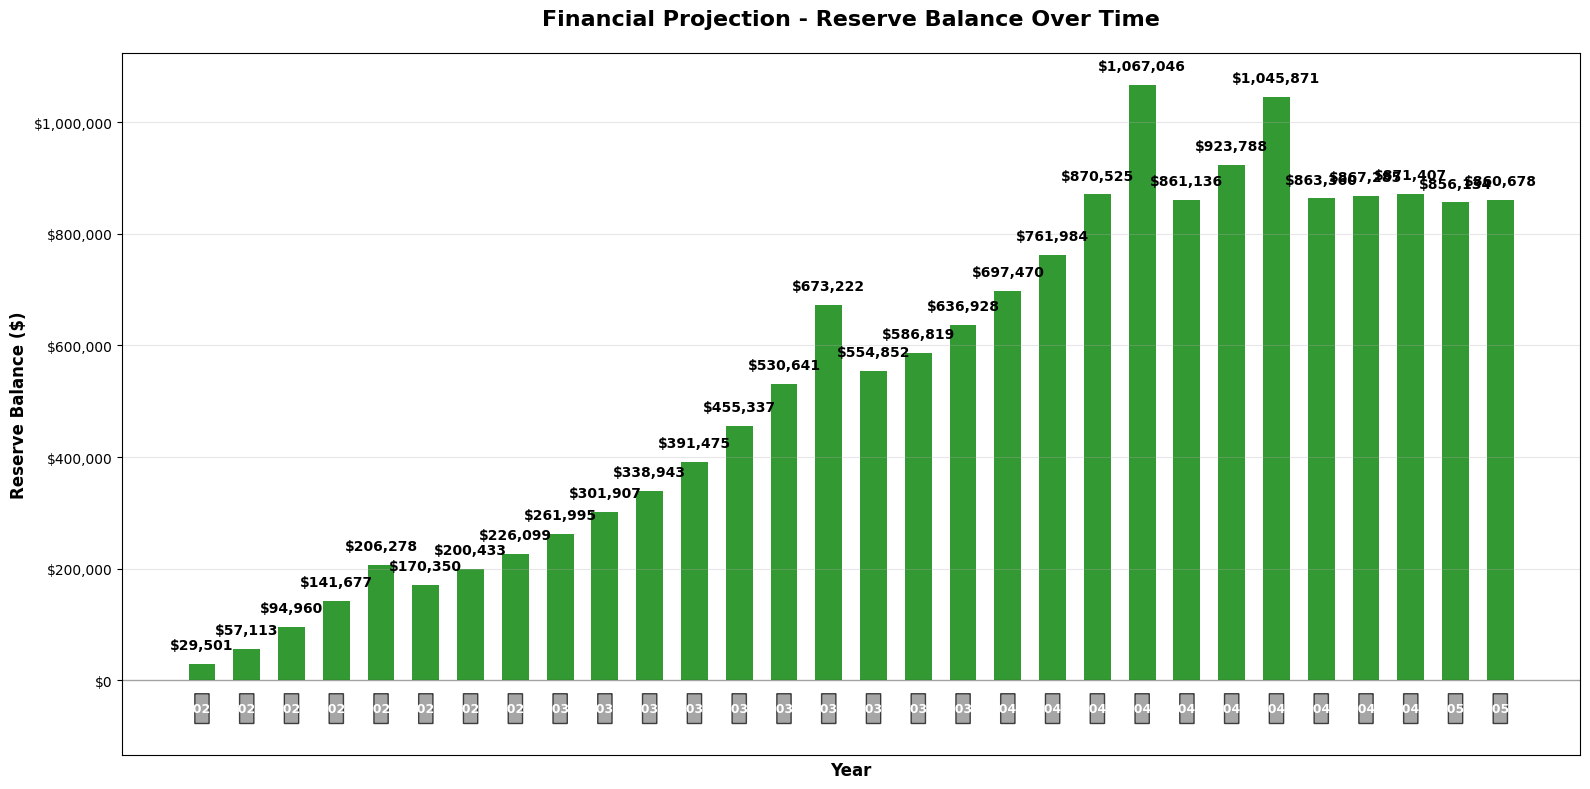


📊 Financial Projection Summary:
   • Positive balance years: 30/30
   • Negative balance years: 0/30
   • Lowest balance: $29,501 (Year 2022)
   • Highest balance: $1,067,046
   • Final balance: $860,678


In [79]:
# Create an enhanced visualization showing remaining balance with positive/negative indicators
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Create the figure and axis
fig, ax = plt.subplots(figsize=(16, 8))

# Extract data for plotting
years = df['year'].values
closing_balances = df['closing_balance'].values

# Create bar positions
x_positions = np.arange(len(years))
bar_width = 0.6

# Create bars with colors based on positive/negative values
colors = ['green' if amount >= 0 else 'red' for amount in closing_balances]

# Create the bar chart
bars = ax.bar(x_positions, closing_balances, width=bar_width, color=colors, alpha=0.8)

# Add value labels on top of each bar
for i, (year, amount) in enumerate(zip(years, closing_balances)):
    # Position label above or below bar depending on positive/negative
    y_pos = amount + (max(closing_balances) * 0.02 if amount >= 0 else min(closing_balances) * 0.02)
    
    # Format the amount as currency
    label = f"${amount:,.0f}"
    if amount < 0:
        label = f"-${abs(amount):,.0f}"
    
    ax.text(i, y_pos, label, ha='center', va='bottom' if amount >= 0 else 'top', 
            fontweight='bold', fontsize=10)

# Add year labels below bars with rounded rectangles
for i, year in enumerate(years):
    # Create a rounded rectangle for year labels
    rect = patches.FancyBboxPatch((i-0.15, min(closing_balances) - max(closing_balances)*0.1), 
                                  0.3, max(closing_balances)*0.05,
                                  boxstyle="round,pad=0.01", 
                                  facecolor='gray', alpha=0.7)
    ax.add_patch(rect)
    
    # Add year text
    ax.text(i, min(closing_balances) - max(closing_balances)*0.075, str(int(year)), 
            ha='center', va='center', color='white', fontweight='bold', fontsize=9)

# Customize the chart
ax.set_title('Financial Projection - Reserve Balance Over Time', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Reserve Balance ($)', fontsize=12, fontweight='bold')

# Format y-axis to show currency
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Add a horizontal line at zero
ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.3)

# Remove x-axis ticks since we have custom year labels
ax.set_xticks([])

# Add grid for better readability
ax.grid(True, alpha=0.3, axis='y')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the chart
plt.show()

# Print summary statistics
positive_years = sum(1 for amount in closing_balances if amount >= 0)
negative_years = len(closing_balances) - positive_years
min_amount = min(closing_balances)
max_amount = max(closing_balances)
min_year = years[np.argmin(closing_balances)]

print("\n📊 Financial Projection Summary:")
print(f"   • Positive balance years: {positive_years}/{len(years)}")
print(f"   • Negative balance years: {negative_years}/{len(years)}")
print(f"   • Lowest balance: ${min_amount:,.0f} (Year {int(min_year)})")
print(f"   • Highest balance: ${max_amount:,.0f}")
print(f"   • Final balance: ${closing_balances[-1]:,.0f}")


In [80]:
# Validation Test - Check key simulation parameters
print("🔍 SIMULATION VALIDATION")
print("=" * 50)
print(f"Monthly Fees: ${MONTHLY_FEES:,.2f}")
print(f"Annual Base Maintenance (Year 1): ${MONTHLY_FEES * 12:,.2f}")
print(f"Optimization Enabled: {OPTIMIZE_MONTHLY_FEES}")
print(f"Inflation Rate: {INFLATION_RATE}%")
print(f"Starting Balance: ${STARTING_BALANCE:,.2f}")
print()

# Check first few years of data
print("📈 FIRST 5 YEARS SUMMARY:")
print("-" * 50)
for i in range(min(5, len(data))):
    year_data = data[i]
    print(f"Year {year_data['year']}:")
    print(f"  • Opening Balance: ${year_data['opening_balance']:,.2f}")
    print(f"  • Base Maintenance: ${year_data['base_maintenance']:,.2f}")
    print(f"  • Total Expenses: ${year_data['future_expenses_in_year']:,.2f}")
    print(f"  • Total Collections: ${year_data['total_maintenance_collected']:,.2f}")
    print(f"  • Closing Balance: ${year_data['closing_balance']:,.2f}")
    print()

# Check for any immediate red flags
negative_years = [year_data for year_data in data if year_data['closing_balance'] < 0]
print(f"⚠️  Years with negative balance: {len(negative_years)}/{len(data)}")
if negative_years:
    print("First few negative balance years:")
    for year_data in negative_years[:3]:
        print(f"  • Year {year_data['year']}: ${year_data['closing_balance']:,.2f}")
        
print("\n✅ Validation complete - check for realistic values above")


🔍 SIMULATION VALIDATION
Monthly Fees: $92.00
Annual Base Maintenance (Year 1): $1,104.00
Optimization Enabled: True
Inflation Rate: 5%
Starting Balance: $0.00

📈 FIRST 5 YEARS SUMMARY:
--------------------------------------------------
Year 2022:
  • Opening Balance: $0.00
  • Base Maintenance: $1,104.00
  • Total Expenses: $0.00
  • Total Collections: $29,501.23
  • Closing Balance: $29,501.23

Year 2023:
  • Opening Balance: $29,501.23
  • Base Maintenance: $1,159.20
  • Total Expenses: $5,250.00
  • Total Collections: $32,861.77
  • Closing Balance: $57,113.01

Year 2024:
  • Opening Balance: $57,113.01
  • Base Maintenance: $1,217.16
  • Total Expenses: $0.00
  • Total Collections: $37,846.66
  • Closing Balance: $94,959.67

Year 2025:
  • Opening Balance: $94,959.67
  • Base Maintenance: $1,278.02
  • Total Expenses: $0.00
  • Total Collections: $46,717.46
  • Closing Balance: $141,677.13

Year 2026:
  • Opening Balance: $141,677.13
  • Base Maintenance: $1,341.92
  • Total Expens

In [82]:
print(df.to_csv())

,year,opening_balance,base_maintenance,future_expenses_in_year,reserve_contribution,loan_repayments,collections_without_safety_net,provisional_end_balance,safety_net_target,safety_net_top_up,total_maintenance_collected,closing_balance,large_expenses,loan_portion,cash_portion,active_loans_count,starting_balance,yearly_collections,total_available_to_invest,total_amount_invested,net_earnings,projected_ltim_earnings,loss_in_purchasing_power,loan_payments,expenses,compound_value_of_savings,remaining_amount,optimized_monthly_fees
0,2022,0.0,1104.0,0.0,28397.234678863326,0.0,29501.234678863326,29501.234678863326,110.4,0,29501.234678863326,29501.234678863326,0.0,0.0,0.0,0,0.0,29501.234678863326,28026.17294492016,0.0,0.0,0.0,1475.0617339431662,0.0,0.0,0.0,26551.111210976993,92
1,2023,29501.234678863326,1159.2,5250.0,31702.57388660385,0.0,32861.77388660385,57113.00856546717,640.9200000000001,0,32861.77388660385,57113.00856546717,0.0,0.0,5250.0,0,29501.234678863326,32861.77388660385,53994.8581371